# Week 30

## 1. Get a list of WL-hashes and the count

In [1]:
import os
import scipy.io
import numpy as np
import pandas as pd
import networkx as nx
from scipy.sparse import issparse
from collections import Counter

def canonical_hash(adj_matrix):
    G = nx.DiGraph(adj_matrix)
    return nx.weisfeiler_lehman_graph_hash(G, node_attr=None, edge_attr=None)

def sanitize_matrix(mat):
    if issparse(mat):
        return mat.toarray().astype(float)
    elif isinstance(mat, np.ndarray) and mat.dtype == object:
        try:
            return np.array([[float(cell) for cell in row] for row in mat], dtype=float)
        except Exception:
            return np.array(mat.tolist(), dtype=float)
    else:
        return np.array(mat, dtype=float)

folder_path = "../../src/matlab/data/result_building_blocks/building_blocks/CGP3_tax_mass"
math_paths = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith(".mat")]

positive_counter = Counter()
positive_subgraphs = {}
negative_subgraphs = []

for path in math_paths:
    mat = scipy.io.loadmat(path)
    if 'ordered_adj' not in mat or 'label' not in mat or 'link' not in mat or 'nodes' not in mat:
        continue

    ordered_adj = sanitize_matrix(mat['ordered_adj'])
    adj_before = sanitize_matrix(mat.get('adj_before', mat.get('adj')))
    nodes = [int(x) for x in mat['nodes'].flatten()]
    label = int(mat['label'][0][0])
    link = tuple(int(x) for x in mat['link'].flatten())

    if link[0] not in nodes or link[1] not in nodes:
        continue

    hash_key = canonical_hash(ordered_adj)

    if label == 1:
        positive_counter[hash_key] += 1
        if hash_key not in positive_subgraphs:
            positive_subgraphs[hash_key] = (adj_before, nodes, link, label)
    else:
        negative_subgraphs.append((adj_before, nodes, link, label))

# Transform the Counter dict to a pandas DataFrame
hash_df = pd.DataFrame(positive_counter.items(), columns=['Hash', 'Count'])
hash_df.sort_values(by='Count', ascending=False, inplace=True)
hash_df.head()

,Hash,Count
5,ea20d167e0ea2d7f4e6c581e33f9730f,7
10,282eda8f0168866762564f11c1572df7,6
18,e55058a8e7ac3a4411851efa887078fa,6
15,5e2d0e12c4309bd6871ee2942a810ee1,5
4,49ad523a0d79291e849f8fafc887d483,4


## 2. Visualize all subgraphs (building blocks) for top 1 WL-hash

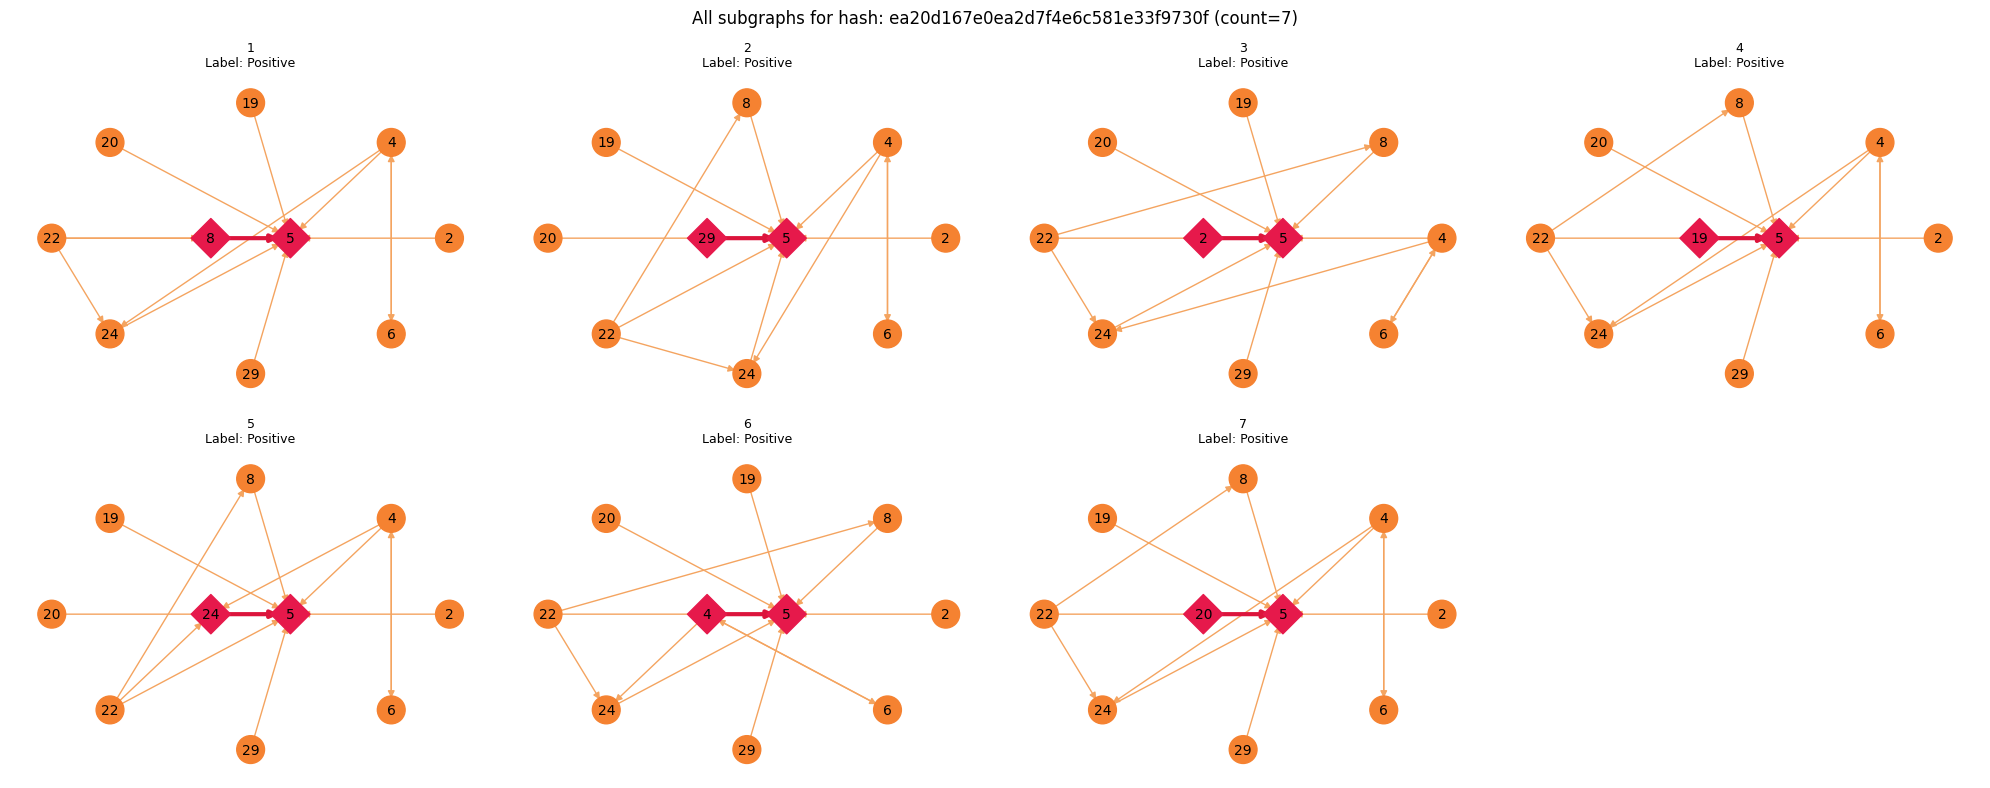

In [2]:
import os
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import random
from scipy.sparse import issparse
from collections import Counter
from math import pi, cos, sin
from networkx.algorithms.isomorphism import DiGraphMatcher

def canonical_hash(adj_matrix):
    G = nx.DiGraph(adj_matrix)
    return nx.weisfeiler_lehman_graph_hash(G, node_attr=None, edge_attr=None)

def sanitize_matrix(mat):
    if issparse(mat):
        return mat.toarray().astype(float)
    elif isinstance(mat, np.ndarray) and mat.dtype == object:
        try:
            return np.array([[float(cell) for cell in row] for row in mat], dtype=float)
        except Exception:
            return np.array(mat.tolist(), dtype=float)
    else:
        return np.array(mat, dtype=float)

def centered_layout(G, link, radius=2.5):
    source, target = link
    pos = {
        source: np.array([-0.5, 0.0]),
        target: np.array([0.5, 0.0])
    }
    remaining = [n for n in G.nodes() if n not in link]
    n = len(remaining)
    if n == 0:
        return pos
    angles = np.linspace(0, 2 * pi, n, endpoint=False)
    for i, node in enumerate(remaining):
        pos[node] = np.array([radius * cos(angles[i]), radius * sin(angles[i])])
    return pos

def draw_graph_on_ax(adj, nodes, link, label, title, ax):
    G = nx.DiGraph()
    G.add_nodes_from(nodes)
    for i, u in enumerate(nodes):
        for j, v in enumerate(nodes):
            if adj[i, j] != 0:
                G.add_edge(u, v)
    pos = centered_layout(G, link)
    highlighted_nodes = {link[0], link[1]}
    node_color = ['#e6194b' if n in highlighted_nodes else '#f58231' for n in G.nodes()]
    node_shapes = ['D' if n in highlighted_nodes else 'o' for n in G.nodes()]

    for shape in set(node_shapes):
        nodelist = [n for n, s in zip(G.nodes(), node_shapes) if s == shape]
        colorlist = [node_color[list(G.nodes()).index(n)] for n in nodelist]
        nx.draw_networkx_nodes(G, pos, nodelist=nodelist, node_color=colorlist, node_shape=shape, node_size=400, ax=ax)
    
    normal_edges = [e for e in G.edges() if e != link]
    nx.draw_networkx_edges(G, pos, edgelist=normal_edges, edge_color='sandybrown', arrows=True, ax=ax)
    nx.draw_networkx_edges(G, pos, edgelist=[link], edge_color='crimson', width=3, arrows=True, ax=ax)
    nx.draw_networkx_labels(G, pos, font_size=10, ax=ax)

    ax.set_title(f"{title}\nLabel: {'Positive' if label == 1 else 'Negative'}", fontsize=9)
    ax.axis('off')

def plot_graphs(subgraphs, titles, suptitle):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    for i, (adj, nodes, link, label) in enumerate(subgraphs):
        draw_graph_on_ax(adj, nodes, link, label, titles[i], axes[i])
    plt.suptitle(suptitle, fontsize=12)
    plt.tight_layout()
    plt.show()

def plot_all_subgraphs_for_hash(subgraph_list, hash_key):
    num = len(subgraph_list)
    cols = 4
    rows = (num + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows))

    if rows == 1:
        axes = np.array([axes])
    axes = axes.flatten()

    for i, (adj, nodes, link, label) in enumerate(subgraph_list):
        draw_graph_on_ax(adj, nodes, link, label, f"{i+1}", axes[i])
    
    for j in range(i + 1, len(axes)):
        axes[j].axis("off")

    plt.suptitle(f"All subgraphs for hash: {hash_key} (count={num})", fontsize=12)
    plt.tight_layout()
    plt.show()

folder_path = "../../src/matlab/data/result_building_blocks/building_blocks/CGP3_tax_mass"
math_paths = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith(".mat")]

positive_counter = Counter()
positive_subgraphs_all = {}
positive_subgraphs = {}
negative_subgraphs = []

for path in math_paths:
    mat = scipy.io.loadmat(path)
    if 'ordered_adj' not in mat or 'label' not in mat or 'link' not in mat or 'nodes' not in mat:
        continue

    ordered_adj = sanitize_matrix(mat['ordered_adj'])
    adj_before = sanitize_matrix(mat.get('adj_before', mat.get('adj')))
    nodes = [int(x) for x in mat['nodes'].flatten()]
    label = int(mat['label'][0][0])
    link = tuple(int(x) for x in mat['link'].flatten())

    if link[0] not in nodes or link[1] not in nodes:
        continue

    hash_key = canonical_hash(ordered_adj)

    if label == 1:
        positive_counter[hash_key] += 1
        if hash_key not in positive_subgraphs:
            positive_subgraphs[hash_key] = (adj_before, nodes, link, label)
        if hash_key not in positive_subgraphs_all:
            positive_subgraphs_all[hash_key] = []
        positive_subgraphs_all[hash_key].append((adj_before, nodes, link, label))
    else:
        negative_subgraphs.append((adj_before, nodes, link, label))

# Top 2 postive subgraphs
most_common_positives = positive_counter.most_common(2)
top1_hash = most_common_positives[0][0]
subgraphs_with_top1 = positive_subgraphs_all[top1_hash]
plot_all_subgraphs_for_hash(subgraphs_with_top1, top1_hash)

## 3. Verifiy isomorphism comparing all the subgraphs wihtin Top 1 group (same WL-hash)

In [1]:
import os
import scipy.io
import numpy as np
import networkx as nx
from scipy.sparse import issparse
from collections import Counter
from networkx.algorithms.isomorphism import DiGraphMatcher

def canonical_hash(adj_matrix):
    G = nx.DiGraph(adj_matrix)
    return nx.weisfeiler_lehman_graph_hash(G, node_attr=None, edge_attr=None)

def sanitize_matrix(mat):
    if issparse(mat):
        return mat.toarray().astype(float)
    elif isinstance(mat, np.ndarray) and mat.dtype == object:
        try:
            return np.array([[float(cell) for cell in row] for row in mat], dtype=float)
        except Exception:
            return np.array(mat.tolist(), dtype=float)
    else:
        return np.array(mat, dtype=float)

def subgraph_isomorphism_validation(subgraph_list):
    if not subgraph_list:
        return True, []
    
    base_adj, _, _, _ = subgraph_list[0]
    G_base = nx.DiGraph(base_adj)

    non_matching_indices = []

    for idx, (adj, _, _, _) in enumerate(subgraph_list[1:], start=1):
        G_other = nx.DiGraph(adj)
        matcher = DiGraphMatcher(G_base, G_other)
        if not matcher.is_isomorphic():
            non_matching_indices.append(idx)
    
    all_match = len(non_matching_indices) == 0
    return all_match, non_matching_indices

folder_path = "../../src/matlab/data/result_building_blocks/building_blocks/Grand Caricaie  marsh dominated by Cladietum marisci, mown  Clmown1_tax_mass"
math_paths = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith(".mat")]

positive_counter = Counter()
positive_subgraphs_all = {}
positive_subgraphs = {}
negative_subgraphs = []

for path in math_paths:
    mat = scipy.io.loadmat(path)
    if 'ordered_adj' not in mat or 'label' not in mat or 'link' not in mat or 'nodes' not in mat:
        continue

    ordered_adj = sanitize_matrix(mat['ordered_adj'])
    adj_before = sanitize_matrix(mat.get('adj_before', mat.get('adj')))
    nodes = [int(x) for x in mat['nodes'].flatten()]
    label = int(mat['label'][0][0])
    link = tuple(int(x) for x in mat['link'].flatten())

    if link[0] not in nodes or link[1] not in nodes:
        continue

    hash_key = canonical_hash(ordered_adj)

    if label == 1:
        positive_counter[hash_key] += 1
        if hash_key not in positive_subgraphs:
            positive_subgraphs[hash_key] = (adj_before, nodes, link, label)
        if hash_key not in positive_subgraphs_all:
            positive_subgraphs_all[hash_key] = []
        positive_subgraphs_all[hash_key].append((adj_before, nodes, link, label))
    else:
        negative_subgraphs.append((adj_before, nodes, link, label))

# Top 2 postive subgraphs
most_common_positives = positive_counter.most_common(2)
top1_hash = most_common_positives[0][0]
subgraphs_with_top1 = positive_subgraphs_all[top1_hash]

all_iso, mismatches = subgraph_isomorphism_validation(subgraphs_with_top1)

if all_iso:
    print(f"All subgraphs for hash {top1_hash} are isomorphic.")
else:
    print(f"{len(mismatches)} subgraphs for hash {top1_hash} are not isomorphic: {mismatches}")

149 subgraphs for hash 9368f2ae9f6c2a76c9c6fc8479c42166 are not isomorphic: [1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 23, 24, 25, 28, 29, 30, 31, 33, 34, 35, 36, 38, 40, 41, 43, 46, 47, 48, 49, 51, 52, 53, 54, 55, 57, 58, 60, 61, 62, 63, 65, 66, 67, 68, 69, 70, 71, 72, 73, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 103, 104, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 119, 120, 122, 124, 125, 126, 127, 128, 129, 130, 131, 132, 134, 137, 138, 139, 141, 142, 143, 144, 145, 146, 147, 148, 150, 151, 152, 153, 154, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 175, 176, 177]


#### We first grouped the subgraphs using WL hashing to cluster candidate building blocks, and then performed full isomorphism validation within each hash group to ensure structural consistency but for big foodwebs there there are some false positives that does not belong to the cluster, also there are some false negatives that could be excluded from the top-1 cluster.

#### We identified building blocks by grouping all positive subgraphs strictly by exact directed isomorphism, without relying on hash-based approximations. This approach, while computationally more intensive, guarantees that the most frequent subgraph patterns (Top-1 and Top-2) are topologically identical, preserving ecological interpretability and robustness.

## 4. Isomorphism based version (without WL-Hashing)


## What is Graph Isomorphism?

Two graphs are **isomorphic** if they are **structurally identical**, even if:

* Their nodes have **different labels or IDs**.
* Their node order or layout is **different**.


## Example in Food Web Terms

Let’s say we extract two K=10 subgraphs:

* One with species labeled `[ 2,  4,  5,  6,  8, 19, 20, 22, 24, 29]`
* Two with species labeled `[10, 12, 13, 14, 16, 25, 26, 28, 30, 35]`

If:

* The **predator-prey relationships** between them are the same (i.e., the same structure of "who eats whom")
* But the **IDs** are different

Then these two subgraphs are **isomorphic**.


## Directed vs. Undirected

In my case:

* Food webs are **directed** (prey → predator), so the **direction of edges matters**.
* `A → B` is **not the same** as `B → A`.

This is handled by using `networkx.DiGraph()` and `DiGraphMatcher()` which checks **directed isomorphism**.


## What Isomorphism *Ignores*

It does **not** consider:

* Node labels or biological identity
* Spatial layout
* Any visual arrangement

Only the **connectivity pattern** matters.


## Why it matters for building blocks

When we group subgraphs by isomorphism:

* You’re saying: *“These structures represent the same functional pattern, regardless of which species are involved.”*
* This gives us a way to **quantify and compare** recurring ecological structures (motifs).


## Key Takeaway

Graph isomorphism allows you to **detect and count the recurrence of structural patterns** in food webs even when node identities vary — which is precisely what you want when identifying **building blocks**.

Top-1 building blocks: 9 isomorphic subgraphs


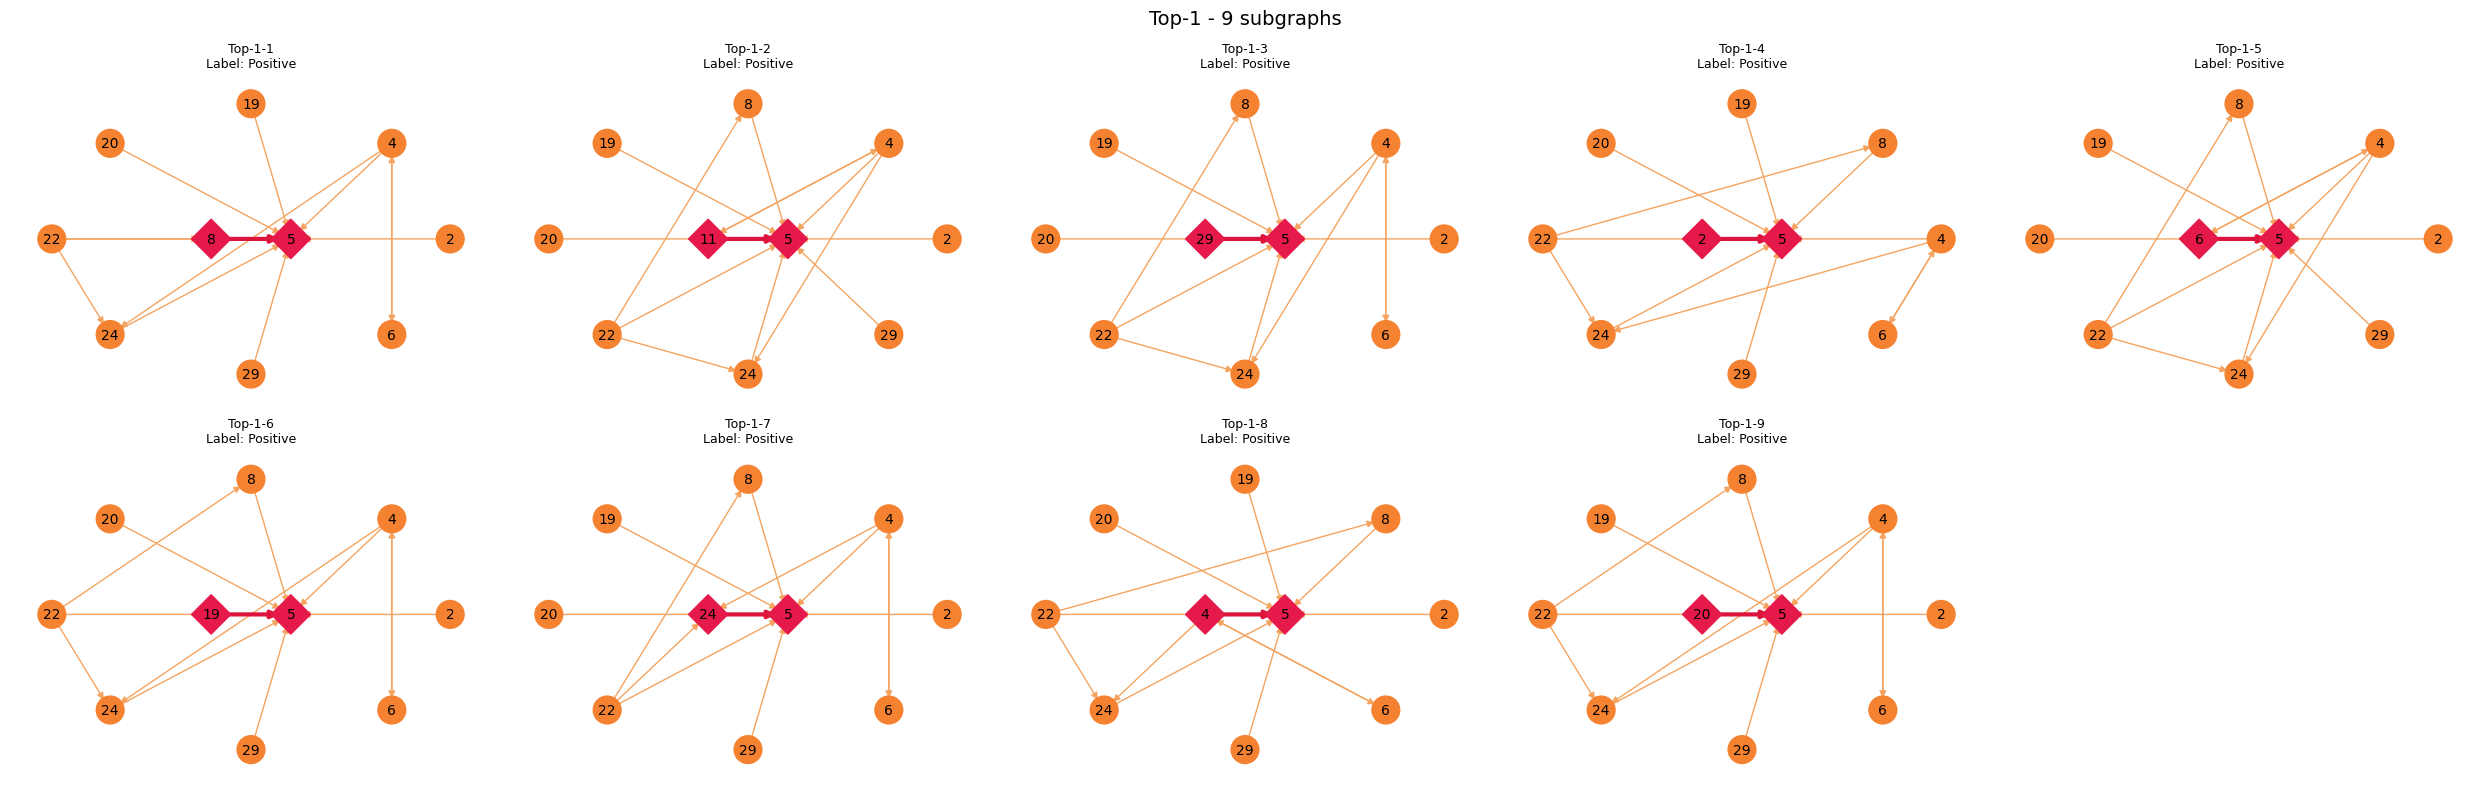

Top-2 building blocks: 6 isomorphic subgraphs


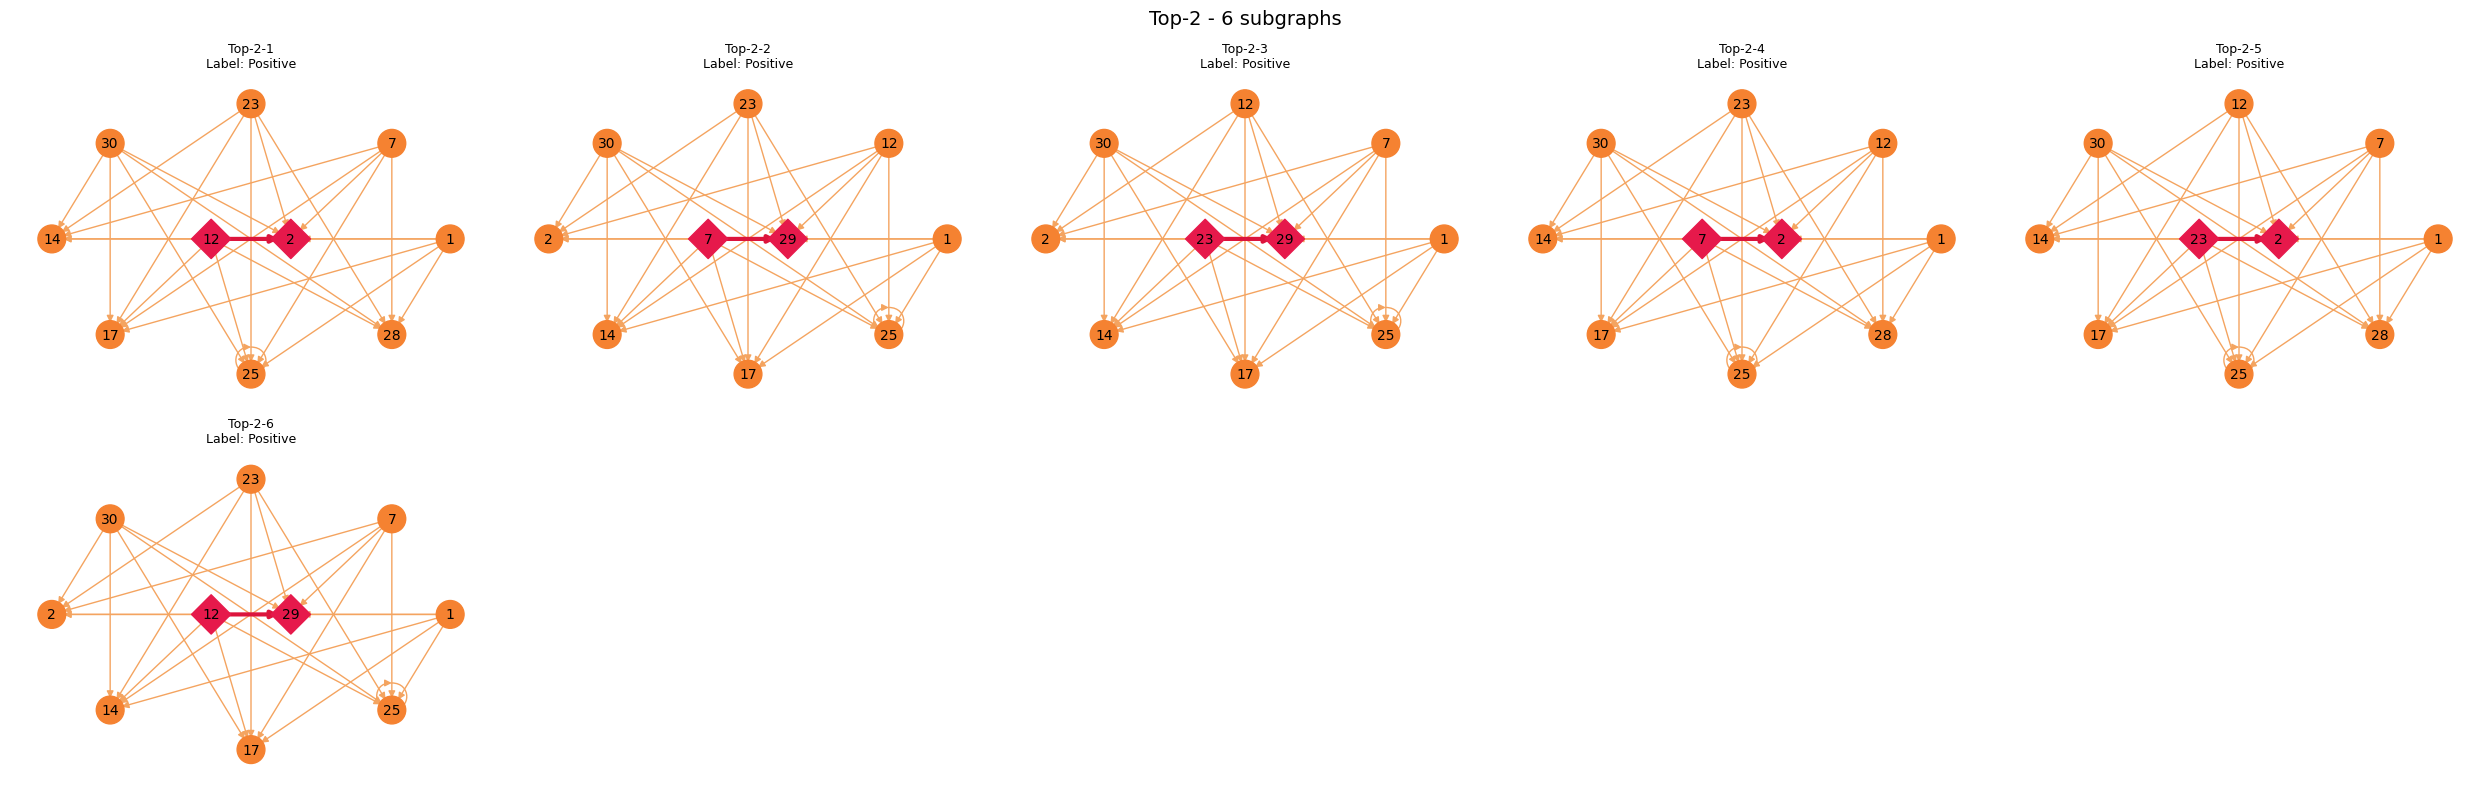

In [2]:
import os
import scipy.io
import numpy as np
import networkx as nx
from scipy.sparse import issparse
from networkx.algorithms.isomorphism import DiGraphMatcher
import matplotlib.pyplot as plt
from math import pi, cos, sin

def sanitize_matrix(mat):
    if issparse(mat):
        return mat.toarray().astype(float)
    elif isinstance(mat, np.ndarray) and mat.dtype == object:
        try:
            return np.array([[float(cell) for cell in row] for row in mat], dtype=float)
        except Exception:
            return np.array(mat.tolist(), dtype=float)
    else:
        return np.array(mat, dtype=float)
    
def centered_layout(G, link, radius=2.5):
    source, target = link
    pos = {
        source: np.array([-0.5, 0.0]),
        target: np.array([0.5, 0.0])
    }
    remaining = [n for n in G.nodes() if n not in link]
    angles = np.linspace(0,2 * pi, len(remaining), endpoint=False)
    for i, node in enumerate(remaining):
        pos[node] = np.array([radius * cos(angles[i]), radius * sin(angles[i])])
    return pos

def draw_graph_on_ax(adj, nodes, link, label, title, ax):
    G = nx.DiGraph()
    G.add_nodes_from(nodes)
    for i, u in enumerate(nodes):
        for j, v in enumerate(nodes):
            if adj[i, j] != 0:
                G.add_edge(u, v)
    pos = centered_layout(G, link)
    highlighted_nodes = {link[0], link[1]}
    node_color = ['#e6194b' if n in highlighted_nodes else '#f58231' for n in G.nodes()]
    node_shapes = ['D' if n in highlighted_nodes else 'o' for n in G.nodes()]
    for shape in set(node_shapes):
        nodelist = [n for n, s in zip(G.nodes(), node_shapes) if s == shape]
        colorlist = [node_color[list(G.nodes()).index(n)] for n in nodelist]
        nx.draw_networkx_nodes(G, pos, nodelist=nodelist, node_color=colorlist, node_shape=shape, node_size=400, ax=ax)
    nx.draw_networkx_edges(G, pos, edgelist=[e for e in G.edges() if e != link], edge_color='sandybrown', arrows=True, ax=ax)
    nx.draw_networkx_edges(G, pos, edgelist=[link], edge_color='crimson', width=3, arrows=True, ax=ax)
    nx.draw_networkx_labels(G, pos, font_size=10, ax=ax)
    ax.set_title(f"{title}\nLabel: {'Positive' if label == 1 else 'Negative'}", fontsize=9)
    ax.axis('off')

def plot_all_subgraphs(subgraph_list, title_prefix):
    num = len(subgraph_list)
    cols = 5
    rows = (num + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows))
    axes = axes.flatten()
    for i, (adj, nodes, link, label) in enumerate(subgraph_list):
        draw_graph_on_ax(adj, nodes, link, label, f"{title_prefix}: {i+1}", axes[i])
    for j in range(i + 1, len(axes)):
        axes[j].axis("off")
    plt.suptitle(f"{title_prefix} - {num} subgraphs", fontsize=14)
    plt.tight_layout()
    plt.show()

def group_subgraphs_by_isomorphism(subgraph_list):
    groups = []
    for adj, nodes, link, label in subgraph_list:
        G = nx.DiGraph(adj)
        matched = False
        for group in groups:
            G_rep = nx.DiGraph(group[0][0])
            if DiGraphMatcher(G, G_rep).is_isomorphic():
                group.append((adj, nodes, link, label))
                matched = True
                break
        if not matched:
            groups.append([(adj, nodes, link, label)])
    return groups

folder_path = "../../src/matlab/data/result_building_blocks/building_blocks/CGP3_tax_mass"
math_paths = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith(".mat")]

positive_subgraphs = []

for path in math_paths:
    mat = scipy.io.loadmat(path)
    if not all(k in mat for k in ['ordered_adj', 'label', 'link', 'nodes']):
        continue
    ordered_adj = sanitize_matrix(mat['ordered_adj'])
    adj_before = sanitize_matrix(mat.get('adj_before', mat.get('adj')))
    nodes = [int(x) for x in mat['nodes'].flatten()]
    label = int(mat['label'][0][0])
    link = tuple(int(x) for x in mat['link'].flatten())
    if link[0] not in nodes or link[1] not in nodes:
        continue
    if label == 1:
        positive_subgraphs.append((adj_before, nodes, link, label))

isomorphic_groups = group_subgraphs_by_isomorphism(positive_subgraphs)
isomorphic_groups = sorted(isomorphic_groups, key=len, reverse=True)

for i, group in enumerate(isomorphic_groups[:2], 1):
    print(f"Top-{i} building blocks: {len(group)} isomorphic subgraphs")
    plot_all_subgraphs(group, f"Top-{i}")

#### To identify recurrent structural Building Blocks within each food web, we extracted all positively labeled K-node subgraphs and grouped them exclusively via exact directed isomorphism using `DiGraphMatcher`. This ensured that each detected building block was structurally canonical, overcoming potential hash collisions that arise in large graphs when relying solely on Weisfeiler-Lehman hashing.

# 5. Top-1 Positive Building Block for all the foodwebs

Scanning food webs: 100%|██████████| 288/288 [01:55<00:00,  2.49it/s]


Total positive subgraphs loaded: 220706


Grouping subgraphs: 100%|██████████| 10000/10000 [07:36<00:00, 21.92it/s]


Top-1 building block: 1956 isomorphic subgraphs


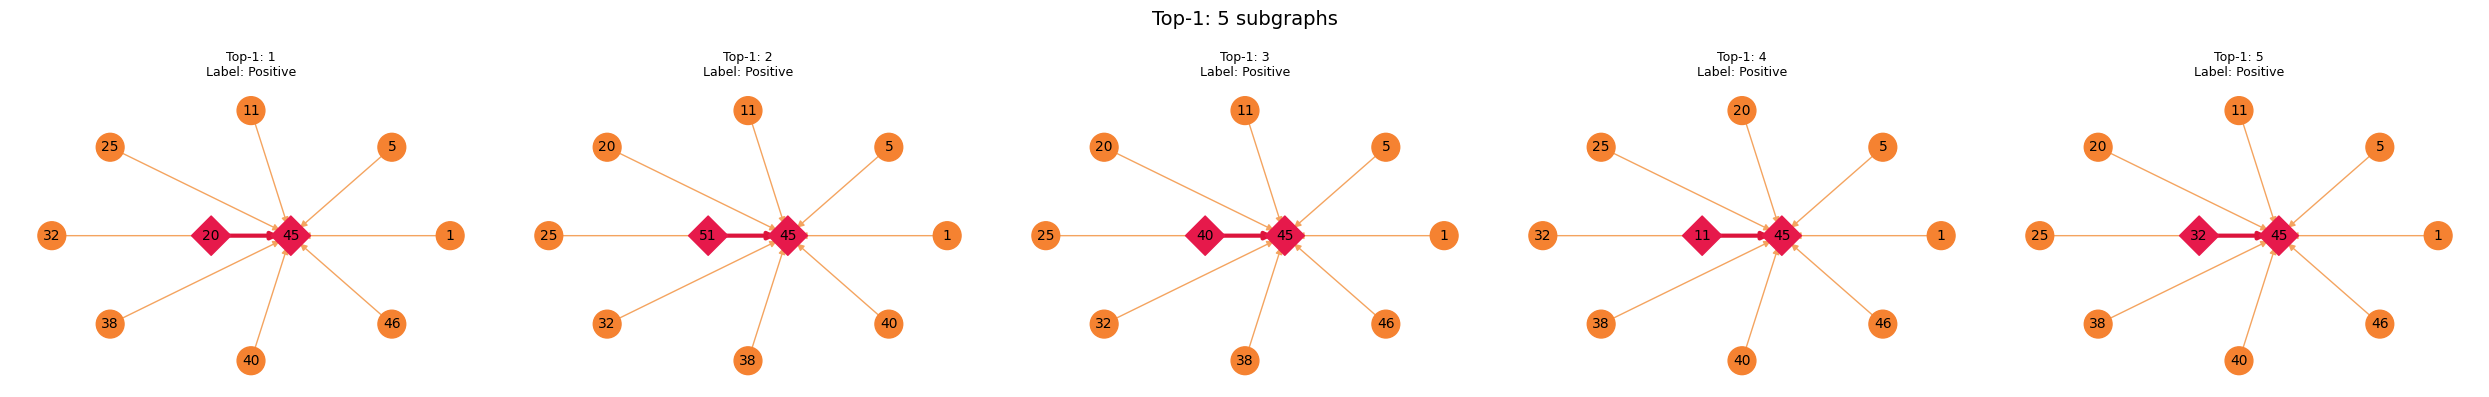

Top-2 building block: 134 isomorphic subgraphs


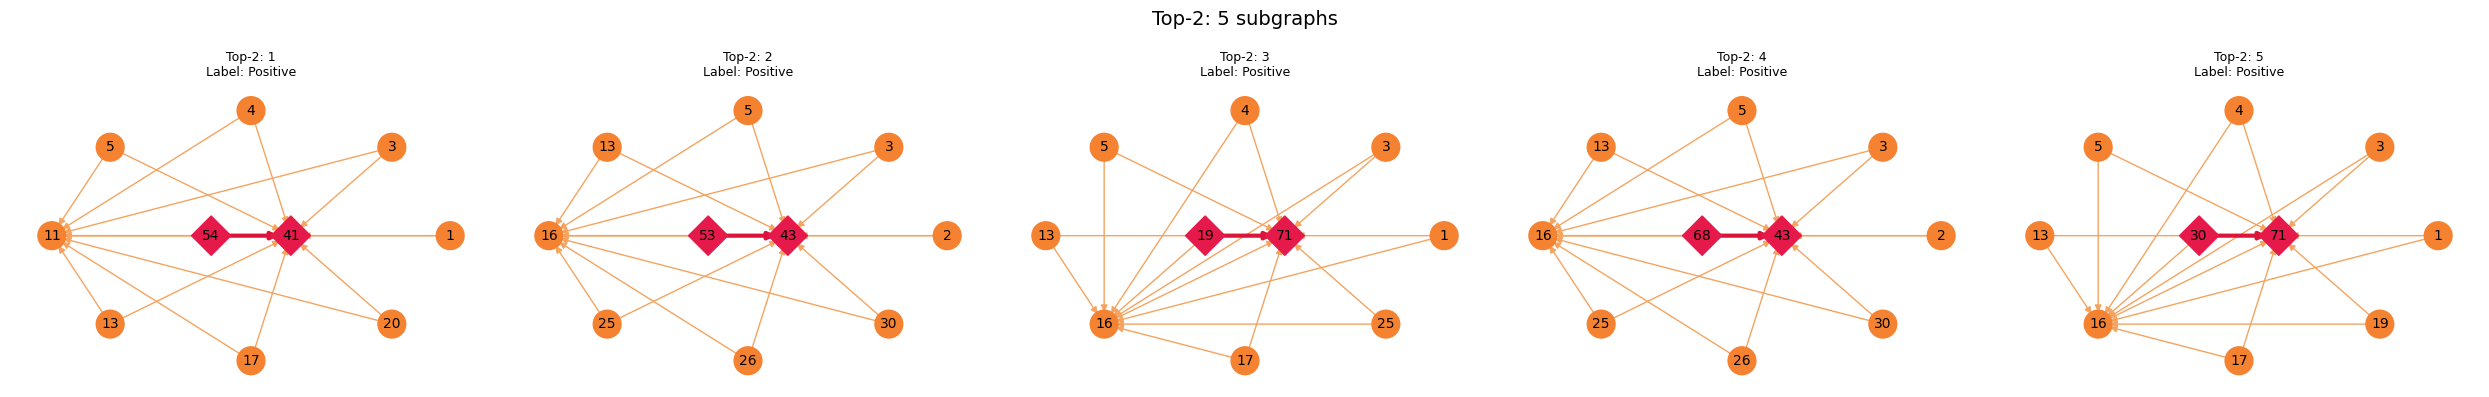

In [1]:
import os
import scipy.io
import numpy as np
import networkx as nx
from scipy.sparse import issparse
from networkx.algorithms.isomorphism import DiGraphMatcher
import matplotlib.pyplot as plt
from math import pi, cos, sin
from tqdm import tqdm

def sanitize_matrix(mat):
    if issparse(mat):
        return mat.toarray().astype(float)
    elif isinstance(mat, np.ndarray) and mat.dtype == object:
        try:
            return np.array([[float(cell) for cell in row] for row in mat], dtype=float)
        except Exception:
            return np.array(mat.tolist(), dtype=float)
    else:
        return np.array(mat, dtype=float)

def centered_layout(G, link, radius=2.5):
    source, target = link
    pos = {
        source: np.array([-0.5, 0.0]),
        target: np.array([0.5, 0.0])
    }
    remaining = [n for n in G.nodes() if n not in link]
    angles = np.linspace(0, 2 * pi, len(remaining), endpoint=False)
    for i, node in enumerate(remaining):
        pos[node] = np.array([radius * cos(angles[i]), radius * sin(angles[i])])
    return pos

def draw_graph_on_ax(adj, nodes, link, label, title, ax):
    G = nx.DiGraph()
    G.add_nodes_from(nodes)
    for i, u in enumerate(nodes):
        for j, v in enumerate(nodes):
            if adj[i, j] != 0:
                G.add_edge(u, v)
    pos = centered_layout(G, link)
    highlighted_nodes = {link[0], link[1]}
    node_color = ['#e6194b' if n in highlighted_nodes else '#f58231' for n in G.nodes()]
    node_shapes = ['D' if n in highlighted_nodes else 'o' for n in G.nodes()]
    for shape in set(node_shapes):
        nodelist = [n for n, s in zip(G.nodes(), node_shapes) if s == shape]
        colorlist = [node_color[list(G.nodes()).index(n)] for n in nodelist]
        nx.draw_networkx_nodes(G, pos, nodelist=nodelist, node_color=colorlist, node_shape=shape, node_size=400, ax=ax)
    nx.draw_networkx_edges(G, pos, edgelist=[e for e in G.edges() if e != link], edge_color='sandybrown', arrows=True, ax=ax)
    nx.draw_networkx_edges(G, pos, edgelist=[link], edge_color='crimson', width=3, arrows=True, ax=ax)
    nx.draw_networkx_labels(G, pos, font_size=10, ax=ax)
    ax.set_title(f"{title}\nLabel: {'Positive' if label == 1 else 'Negative'}", fontsize=9)
    ax.axis('off')

def plot_all_subgraphs(subgraph_list, title_prefix):
    num = len(subgraph_list)
    cols = 5
    rows = (num + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows))
    axes = axes.flatten()
    for i, (adj, nodes, link, label) in enumerate(subgraph_list):
        draw_graph_on_ax(adj, nodes, link, label, f"{title_prefix}: {i+1}", axes[i])
    for j in range(i + 1, len(axes)):
        axes[j].axis("off")
    plt.suptitle(f"{title_prefix}: {num} subgraphs", fontsize=14)
    plt.tight_layout()
    plt.show()

def group_subgraphs_by_isomorphism(subgraph_list):
    groups = []
    for adj, nodes, link, label in tqdm(subgraph_list, desc="Grouping subgraphs"):
        G = nx.DiGraph(adj)
        matched = False
        for group in groups:
            G_rep = nx.DiGraph(group[0][0])
            if DiGraphMatcher(G, G_rep).is_isomorphic():
                group.append((adj, nodes, link, label))
                matched = True
                break
        if not matched:
            groups.append([(adj, nodes, link, label)])
    return groups

root_folder = "../../src/matlab/data/result_building_blocks/building_blocks"
positive_subgraphs = []

subfolders = [os.path.join(root_folder, d) for d in os.listdir(root_folder) if os.path.isdir(os.path.join(root_folder, d))]

for folder in tqdm(subfolders, desc="Scanning food webs"):
    mat_paths = [os.path.join(folder, f) for f in os.listdir(folder) if f.endswith(".mat")]
    for path in mat_paths:
        try:
            mat = scipy.io.loadmat(path)
            if not all(k in mat for k in ['ordered_adj', 'label', 'link', 'nodes']):
                continue
            adj_before = sanitize_matrix(mat.get('adj_before', mat.get('adj')))
            nodes = [int(x) for x in mat['nodes'].flatten()]
            label = int(mat['label'][0][0])
            link = tuple(int(x) for x in mat['link'].flatten())
            if link[0] not in nodes or link[1] not in nodes:
                continue
            if label == 1:
                positive_subgraphs.append((adj_before, nodes, link, label))
        except Exception as e:
            print(f"Error processing {path}: {e}")

print(f"Total positive subgraphs loaded: {len(positive_subgraphs)}")
positive_subgraphs = positive_subgraphs[:10000]
isomorphic_groups = group_subgraphs_by_isomorphism(positive_subgraphs)
isomorphic_groups = sorted(isomorphic_groups, key=len, reverse=True)

for i, group in enumerate(isomorphic_groups[:2], 1):
    print(f"Top-{i} building block: {len(group)} isomorphic subgraphs")
    plot_all_subgraphs(group[:5], f"Top-{i}")

Scanning food webs: 100%|██████████| 288/288 [02:03<00:00,  2.33it/s]


Total positive subgraphs loaded: 220706


Grouping subgraphs: 100%|██████████| 100000/100000 [13:57:30<00:00,  1.99it/s]      


Top-1 building block: 17321 isomorphic subgraphs


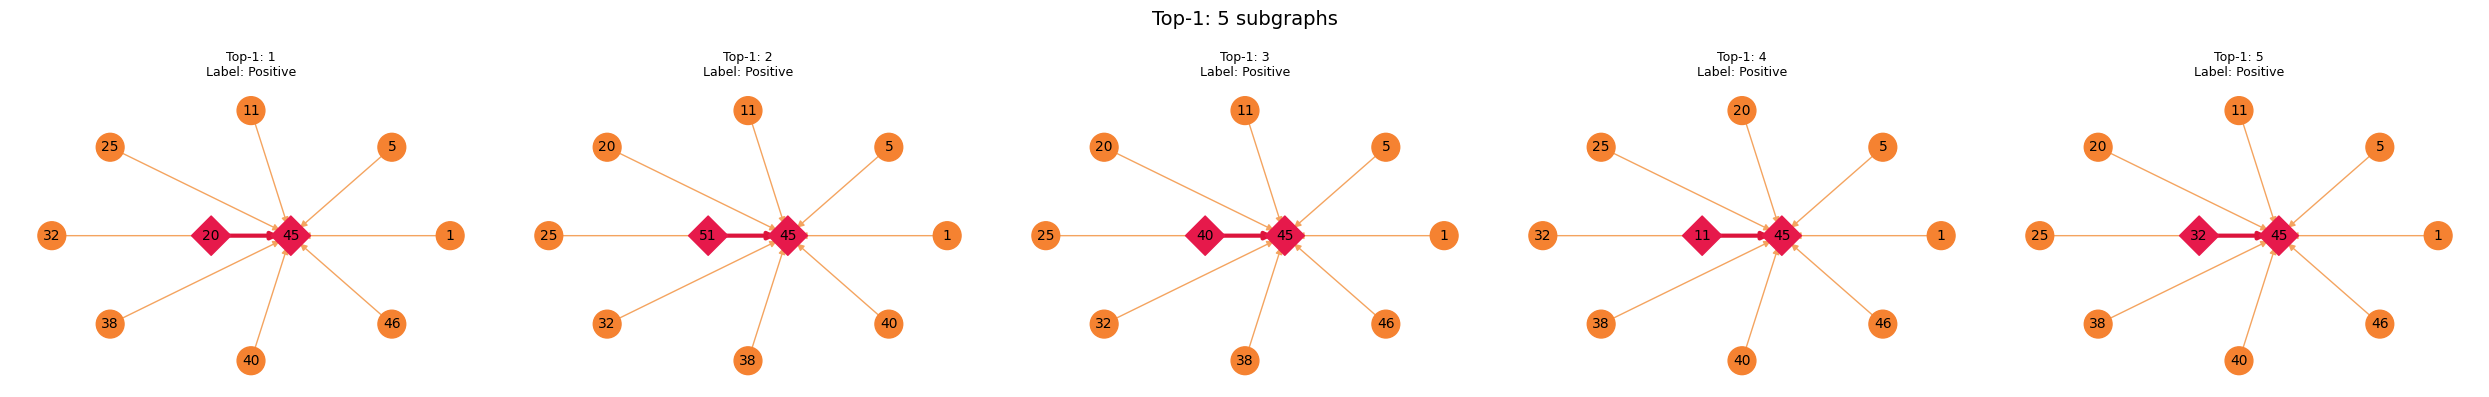

Top-2 building block: 1407 isomorphic subgraphs


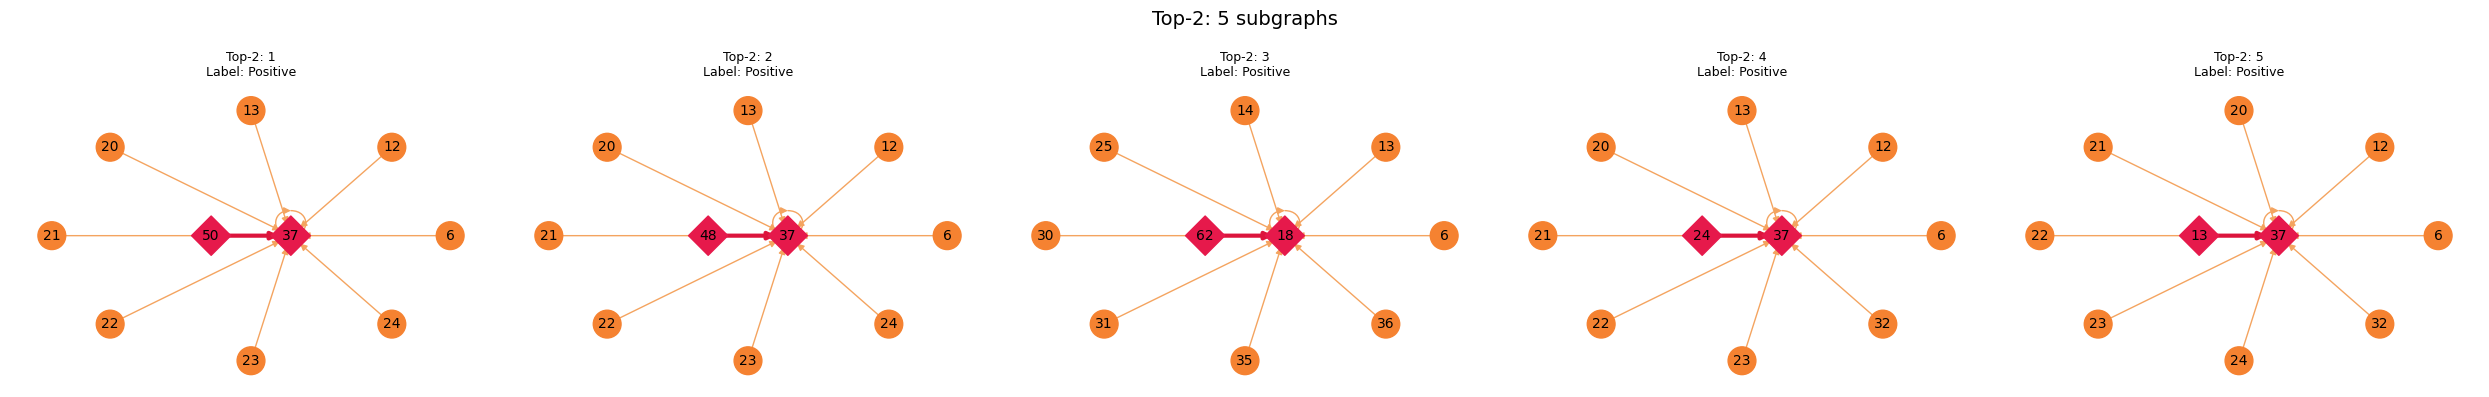

In [1]:
import os
import scipy.io
import numpy as np
import networkx as nx
from scipy.sparse import issparse
from networkx.algorithms.isomorphism import DiGraphMatcher
import matplotlib.pyplot as plt
from math import pi, cos, sin
from tqdm import tqdm

def sanitize_matrix(mat):
    if issparse(mat):
        return mat.toarray().astype(float)
    elif isinstance(mat, np.ndarray) and mat.dtype == object:
        try:
            return np.array([[float(cell) for cell in row] for row in mat], dtype=float)
        except Exception:
            return np.array(mat.tolist(), dtype=float)
    else:
        return np.array(mat, dtype=float)

def centered_layout(G, link, radius=2.5):
    source, target = link
    pos = {
        source: np.array([-0.5, 0.0]),
        target: np.array([0.5, 0.0])
    }
    remaining = [n for n in G.nodes() if n not in link]
    angles = np.linspace(0, 2 * pi, len(remaining), endpoint=False)
    for i, node in enumerate(remaining):
        pos[node] = np.array([radius * cos(angles[i]), radius * sin(angles[i])])
    return pos

def draw_graph_on_ax(adj, nodes, link, label, title, ax):
    G = nx.DiGraph()
    G.add_nodes_from(nodes)
    for i, u in enumerate(nodes):
        for j, v in enumerate(nodes):
            if adj[i, j] != 0:
                G.add_edge(u, v)
    pos = centered_layout(G, link)
    highlighted_nodes = {link[0], link[1]}
    node_color = ['#e6194b' if n in highlighted_nodes else '#f58231' for n in G.nodes()]
    node_shapes = ['D' if n in highlighted_nodes else 'o' for n in G.nodes()]
    for shape in set(node_shapes):
        nodelist = [n for n, s in zip(G.nodes(), node_shapes) if s == shape]
        colorlist = [node_color[list(G.nodes()).index(n)] for n in nodelist]
        nx.draw_networkx_nodes(G, pos, nodelist=nodelist, node_color=colorlist, node_shape=shape, node_size=400, ax=ax)
    nx.draw_networkx_edges(G, pos, edgelist=[e for e in G.edges() if e != link], edge_color='sandybrown', arrows=True, ax=ax)
    nx.draw_networkx_edges(G, pos, edgelist=[link], edge_color='crimson', width=3, arrows=True, ax=ax)
    nx.draw_networkx_labels(G, pos, font_size=10, ax=ax)
    ax.set_title(f"{title}\nLabel: {'Positive' if label == 1 else 'Negative'}", fontsize=9)
    ax.axis('off')

def plot_all_subgraphs(subgraph_list, title_prefix):
    num = len(subgraph_list)
    cols = 5
    rows = (num + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows))
    axes = axes.flatten()
    for i, (adj, nodes, link, label) in enumerate(subgraph_list):
        draw_graph_on_ax(adj, nodes, link, label, f"{title_prefix}: {i+1}", axes[i])
    for j in range(i + 1, len(axes)):
        axes[j].axis("off")
    plt.suptitle(f"{title_prefix}: {num} subgraphs", fontsize=14)
    plt.tight_layout()
    plt.show()

def group_subgraphs_by_isomorphism(subgraph_list):
    groups = []
    for adj, nodes, link, label in tqdm(subgraph_list, desc="Grouping subgraphs"):
        G = nx.DiGraph(adj)
        matched = False
        for group in groups:
            G_rep = nx.DiGraph(group[0][0])
            if DiGraphMatcher(G, G_rep).is_isomorphic():
                group.append((adj, nodes, link, label))
                matched = True
                break
        if not matched:
            groups.append([(adj, nodes, link, label)])
    return groups

root_folder = "../../src/matlab/data/result_building_blocks/building_blocks"
positive_subgraphs = []

subfolders = [os.path.join(root_folder, d) for d in os.listdir(root_folder) if os.path.isdir(os.path.join(root_folder, d))]

for folder in tqdm(subfolders, desc="Scanning food webs"):
    mat_paths = [os.path.join(folder, f) for f in os.listdir(folder) if f.endswith(".mat")]
    for path in mat_paths:
        try:
            mat = scipy.io.loadmat(path)
            if not all(k in mat for k in ['ordered_adj', 'label', 'link', 'nodes']):
                continue
            adj_before = sanitize_matrix(mat.get('adj_before', mat.get('adj')))
            nodes = [int(x) for x in mat['nodes'].flatten()]
            label = int(mat['label'][0][0])
            link = tuple(int(x) for x in mat['link'].flatten())
            if link[0] not in nodes or link[1] not in nodes:
                continue
            if label == 1:
                positive_subgraphs.append((adj_before, nodes, link, label))
        except Exception as e:
            print(f"Error processing {path}: {e}")

print(f"Total positive subgraphs loaded: {len(positive_subgraphs)}")
positive_subgraphs = positive_subgraphs[:100000]
isomorphic_groups = group_subgraphs_by_isomorphism(positive_subgraphs)
isomorphic_groups = sorted(isomorphic_groups, key=len, reverse=True)

for i, group in enumerate(isomorphic_groups[:2], 1):
    print(f"Top-{i} building block: {len(group)} isomorphic subgraphs")
    plot_all_subgraphs(group[:5], f"Top-{i}")

## What WLNM Requires for Link Prediction

In the **original WLNM paper** by Zhang et al. (2017), the link prediction task is framed as follows:

* The model is trained on *existing links (positive)* and *non-links (negative)*.

* For each **candidate link (i, j)**, a **subgraph** is extracted from the full graph ***after removing the link*** (if it exists).

* This simulates the scenario: *“What would the local subgraph look like if we didn’t know this link existed?”*

* Then, Weisfeiler-Lehman subtree labels are used to encode the subgraph into a vector, and an FFNN is trained to predict whether this link exists.

> This is **crucial**: *The link (i, j) must be removed before subgraph extraction*, even for **positive examples**, to avoid data leakage.


## **How We Are Currently Doing It**
From MATLAB implementation, following is what we're doing for each positive and negative sample:

### For **positive links** `(i, j)`:

* We **explicitly remove the link** `(i, j)` inside the function `subgraph2vector` by setting `subgraph(1,2) = 0` and `subgraph(2,1) = 0` after subgraph extraction.
* We then **expand the enclosing subgraph** around `(i, j)` using breadth-like traversal (`neighbors_vectorized`) up to a max depth.
* We apply **Weisfeiler-Lehman relabeling** via `g_label()`, and extract the **upper triangle of the relabeled adjacency matrix** (`plweight_subgraph`) as the final encoding.

### For **negative links** `(i, j)`:

* The link does not exist in `A`, so the subgraph is extracted without modification.
* The same expansion and relabeling pipeline is used via `subgraph2vector`.

> **This is correct.** We are **removing the target positive link** before subgraph extraction and encoding to avoid information leakage, in line with the WLNM protocol described by Zhang et al. (2017).


## Final Verdict

| Step                                            | My Code   | WLNM Paper  |
| ----------------------------------------------- | --------- | ----------- |
| Remove positive link before subgraph extraction | ✅ Yes    | ✅ Yes      |
| Subgraph size fixed (K)                         | ✅ Yes    | ✅ Yes      |
| Twice negatives vs positives samples            | ✅ Yes    | ✅ Yes      |
| Evaluation via AUC                              | ✅ Yes    | ✅ Yes      |


---

#  Implement missing link prediction problem using a trait-aware stacked model, based on the methodology from the paper ***“Predicting missing links in food webs using stacked models and species traits”***.

---


### **Introduction**

Food webs are often incompletely observed, meaning many real feeding interactions between species are missing from empirical datasets.

The stacked model addresses this limitation by **combining multiple individual link predictors**—both **topological features** (e.g., connectivity patterns) and **trait-based features** (e.g., body mass, feeding mode, trophic level)—within a **meta-learning framework**.

This approach allows the model to **learn from ecological constraints** such as link directionality and hierarchical structure.

Applied to a large global dataset of 290 food webs (Brose Dataset), the stacked model consistently outperforms structure-only or trait-only approaches, achieving **highly accurate missing link predictions**.

### **Results**

The stacked model was evaluated on synthetic networks and 290 empirical food webs using three configurations:

1. **Structure-only predictors**
2. **Attribute-only predictors**
3. **Full model combining both**

On **synthetic networks**, the full model consistently exceeded the performance of single-predictor models across varying network structures and attribute mixing levels, achieving ROC-AUC values close to theoretical maximums.

On **empirical food webs**, the full model achieved the highest average ROC-AUC (\~0.95) and PR-AUC (\~0.68), outperforming both structure-only and attribute-only models.

It performed particularly well for **terrestrial belowground** and **larger food webs**, suggesting better trait resolution and ecological predictability in these ecosystems.

Feature importance analysis revealed that **structural predictors** (e.g., K-nearest neighbors, ecological preferential attachment) and **trait-based predictors** (e.g., body mass ratio) were both influential. Structural features dominated overall, but traits improved prediction in specific ecosystems.

Further analysis showed:

* Networks with **low modularity** and **high connectance** had better prediction performance.
* Missing link prediction was easier where fewer species lacked taxonomic classification.
* The model was robust across diverse ecosystems, with terrestrial and freshwater systems showing the highest predictive accuracy.


### **Methods and Materials**

#### **1. Problem Definition and Training Data Construction**

* The network $G = (V, E)$ represents the *true* food web with all links.
* The observed network $G' = (V, E')$ contains a subset of links ($E' \subset E$).
* Candidate missing links are all unconnected pairs $(i, j) \in V \times V - E'$.
* Training data:

  * **Positive class:** Links in $E - E'$ (potentially missing links).
  * **Negative class:** Non-links $(i, j) \notin E$.
* To create training sets:

  * Randomly sample 20% of observed links and hide them.
  * Use these hidden links as positive examples.
  * Use remaining non-links as negatives.
  * Perform **5-fold cross-validation**.

---

#### **2. Stacked Model Training**

* The **stacked model** combines multiple base predictors:

  * Each predictor outputs a score for every potential link.
  * A **meta-learning algorithm** (e.g., random forest) is trained to combine these scores.
* Hyperparameters are tuned via grid search and selected based on **highest PR-AUC** on the validation set.
* The approach learns from:

  * **Structural predictors**: network topology features.
  * **Attribute predictors**: species traits.
* The final model outputs a probability of each candidate link being real.

---

#### **3. Synthetic Network Experiments**

* Two types of synthetic networks are generated:

  1. **Stochastic Block Model (SBM)**: Encodes modular structure typical of trophic interactions.
  2. **Random Geometric Graph (RGG)**: Encodes attribute-based structure using species traits (binary or numeric).
* Networks are mixed with varying proportions ($\rho$) of structure-driven and attribute-driven edges.
* This setup allows testing model performance under different ecological assumptions.

---

#### **4. Structural Predictors**

* **47 topological features** (e.g., degree, centrality, clustering, Katz, PageRank).
* Includes **ecologically informed metrics**:

  * **Preferential attachment (PA):** $PA(i,j) = deg^+(i) \times deg^-(j)$.
  * **Ecological PA (EPA):** Adjusts PA to account for energy flow (producers → consumers).
  * Modified common neighbors and Jaccard indices respecting food web directionality.
* Predictors are computed for each candidate link $(i, j)$.

---

#### **5. Attribute-Based Predictors**

* **Species traits** include:

  * Metabolic type (categorical)
  * Movement type (categorical)
  * Log-transformed body mass (numeric)
* **29 attribute predictors** derived from:

  * Euclidean, Manhattan, Cosine distances between trait vectors.
  * Jaccard distances for binary traits.
  * Log-mass ratios.
* Used to model assortative (similar traits) or disassortative (different traits) interactions.

---

#### **6. Nearest-Neighbor Predictors**

* **K-Nearest Neighbors (KNN)** predictors evaluate:

  * Whether a prey’s nearest predator resembles candidate predator $i$.
  * Whether a predator’s nearest prey resembles candidate prey $j$.
* Uses different distance metrics:

  * Euclidean, Manhattan, Cosine, Jaccard.
* K set to 3; generates 12 additional predictors (6 for inbound, 6 for outbound).

---

#### **7. Meta-Learner and Evaluation**

* Base predictors → combined into a **stacked meta-model** (Random Forest).
* Evaluation metrics:

  * **ROC-AUC:** Ability to distinguish true vs. false links.
  * **PR-AUC:** Precision-recall performance under class imbalance.
* Model performance tested:

  * Across synthetic networks with different $\rho$.
  * Across 290 empirical food webs spanning 5 ecosystem types.
* Importance of each predictor is quantified using **Gini importance**.

This structured approach allows the model to **combine multiple structural and trait-based signals** to robustly predict missing links and identify which ecological features drive link formation.

## **Proposal – Next Steps for Implementing Stacked Model for Missing Link Prediction**

---

### **1. Define Scope and Objectives**

* **Goal:** Implement and test a stacked model combining **structural** and **trait-based predictors** for predicting missing trophic links.
* **Comparison:** Benchmark against WLNM on representative food webs.
* **Outcome:** Evaluate ROC-AUC, PR-AUC, and analyze feature importance to understand ecological drivers.

---

### **2. Data Preparation**

* **Input data:**

  * Food web adjacency matrices (`net` or `predation_matrix`).
  * Species traits: `body mass`, `metabolic type`, `movement type`, taxonomy.
* **Create dataset:**

  * Enumerate all possible species pairs $(i, j)$.
  * Label:

    * `1` = existing link.
    * `0` = non-link.
  * Generate **train/test splits**:

    * Randomly remove a subset of links (20%) as “missing links” for testing.
* **Output:** Pandas DataFrame with columns:

  ```
  predator, prey, label, [structural_features...], [trait_features...]
  ```

---

### **3. Feature Engineering**

* **Structural predictors:**

  * Compute degree-based, path-based, and motif-based metrics (47 as per paper).
  * Adapt for directionality (EPA, ECN).
* **Trait-based predictors:**

  * Mass ratio (log-scale).
  * Trait similarity metrics (Euclidean, Jaccard).
  * One-hot encoded categorical traits.
* **KNN predictors:**

  * Implement KNN similarity scores (in/out neighbors) as described.

---

### **4. Model Architecture**

* **Base learners:** Individual predictors for each feature.
* **Meta-learner:**

  * Random Forest Classifier (or Gradient Boosting).
  * Trained on scores from base predictors to output final probability.
* **Cross-validation:**

  * 5-fold CV on each food web.
  * Tune hyperparameters based on PR-AUC.

---

### **5. Implementation Plan**

* [ ] **Step 1:** Create a Python module for generating training data with labels.
* [ ] **Step 2:** Implement functions to compute all structural and trait-based predictors.
* [ ] **Step 3:** Build and train base models and meta-learner.
* [ ] **Step 4:** Evaluate on test folds; compute ROC-AUC and PR-AUC.
* [ ] **Step 5:** Compare results with WLNM on same datasets.
* [ ] **Step 6:** Visualize predictor importances and ecosystem-type performance.

---

### **6. Deliverables**

* Python package for stacked model training and prediction.
* Scripts for:

  * Data preprocessing.
  * Feature extraction.
  * Cross-validation.
* Benchmark results against WLNM.
* Visual reports: boxplots, ROC/PR curves, feature importance rankings.

---

### **7. Timeline**

* **Week 1:** Data preparation and labeling strategy.
* **Week 2–3:** Implement feature computation.
* **Week 4:** Stacked model training and initial testing.
* **Week 5:** Full benchmarking and visualization.
